### Library Requirements

In [19]:
import numpy as np
import mkl
mkl.get_max_threads()
import bob.learn.em
import os
import speechpy
import torchaudio
import scipy
import torch
import time

### Audio Pre-processing Functions

In [2]:
def load_audio(path, norm=False):
    sound, _ = torchaudio.load(path, normalization=norm)
    sound = sound.numpy()
    if len(sound.shape) > 1:
        if sound.shape[1] == 1:
            sound = sound.squeeze()
        else:
            sound = sound.mean(axis=1)  # multiple channels, average
    return sound

In [3]:
def vec2frames(vec, Nw, Ns, direction='col', window='hamming', padding=False):
    L = len(vec)
    M = int(np.floor((L-Nw)/Ns + 1))

    E = (L - ((M-1) * Ns + Nw))
    if padding:
        if E > 0:
            P = Nw - E
            vec.append(np.zeros(P))
            M += 1

    if direction == 'col':
        indf = np.multiply(range(M), Ns)
        indf = np.expand_dims(indf, axis = 0)
        indf = np.repeat(indf, Nw, axis = 0)

        inds = np.transpose(np.arange(0, Nw))
        inds = np.expand_dims(inds, axis = 1)
        inds = np.repeat(inds, M, axis = 1)

        indices = np.transpose(np.add(indf, inds))

    frames = vec[indices]

    if window == 'hamming':
        window = np.hamming(Nw)
        frames = np.transpose(frames * window)

    return frames

In [4]:
def parse_audio_mfe(audio_path, frame_len):
    
    y = load_audio(audio_path, True)
    
    signal = y.squeeze()
    
    mfe, _ = speechpy.mfe(signal, sampling_frequency=16000, frame_length=0.020, frame_stride=0.01,
         num_filters=40, fft_length=512, low_frequency=0, high_frequency=None)
    
    mfe = torch.FloatTensor(mfe)
    
    output_frame = torch.zeros(1, frame_len, 40)
    seq_length = mfe.size(0)
    
    try:
        start = np.random.randint(0, seq_length-frame_len)
        output_frame[0].copy_(spect.narrow(0, start, frame_len))
    except:
        output_frame[0].narrow(0, 0, seq_length).copy_(mfe)
    
    return output_frame

### MFC Feature Vector Extraction

In [5]:
n_bank =  40
frame_len = 100

file_train, file_val, file_test = [], [], []
spk_train, spk_val, spk_test = [], [], []
frame_train, frame_val, frame_test = np.zeros((1, frame_len, n_bank)), np.zeros((1, frame_len, n_bank)), \
    np.zeros((1, frame_len, n_bank))

list_dict = {'train': [file_train, spk_train, frame_train], 'val': [file_val, spk_val, frame_val],
             'test': [file_test, spk_test, frame_test]}

count=0
for tag, lst in list_dict.items():
    with open('sv_{}_manifest.csv'.format(tag), 'r') as f:
        lines = f.readlines()
        for line in lines:
            count += 1
            parsed = line.strip().split(',')
            lst[0].append(parsed[0])
            lst[1].append(int(parsed[1]))
            #lst[1] = np.append(lst[1], parse_audio_ext(parsed[0], 150).numpy())
            lst[2] = np.append(lst[2], parse_audio_mfe(parsed[0], frame_len).numpy(), axis = 0)
            if tag=='train':
                if count == 5000:
                    count = 0
                    break
            else:
                if count == 800:
                    count = 0
                    break

In [6]:
frame_train = list_dict['train'][2]
frame_train = np.delete(frame_train, 0, axis = 0)
frame_train_unrolled = np.reshape(frame_train, (-1, 40))

frame_val = list_dict['val'][2]
frame_val = np.delete(frame_val, 0, axis = 0)
frame_val_unrolled = np.reshape(frame_val, (-1, 40))

frame_test = list_dict['test'][2]
frame_test = np.delete(frame_test, 0, axis = 0)
frame_test_unrolled = np.reshape(frame_test, (-1, 40))

In [7]:
file_concat = list_dict['val'][0] + list_dict['test'][0]
spk_concat = list_dict['val'][1] + list_dict['test'][1]

### GMM Constants

In [13]:
n_gaussians = 1024
n_inputs = 40
max_iterations = 1000
convergence_threshold = 1e-5
subspace_dimension_of_t = 40

### UBM Training

In [8]:
#Concatenation version of UBM trainer function, now not in use
'''
ubm_gmm = bob.learn.em.GMMMachine(n_gaussians, n_inputs)

ubm_gmm.means = np.zeros((n_gaussians, n_inputs))

ubm_gmm_trainer = bob.learn.em.ML_GMMTrainer(True, True, True)

bob.learn.em.train(ubm_gmm_trainer, ubm_gmm, frame_train_unrolled,
                  max_iterations=max_iterations,
                  convergence_threshold = convergence_threshold)
'''

'\nubm_gmm = bob.learn.em.GMMMachine(n_gaussians, n_inputs)\n\nubm_gmm.means = np.zeros((n_gaussians, n_inputs))\n\nubm_gmm_trainer = bob.learn.em.ML_GMMTrainer(True, True, True)\n\nbob.learn.em.train(ubm_gmm_trainer, ubm_gmm, frame_train_unrolled,\n                  max_iterations=max_iterations,\n                  convergence_threshold = convergence_threshold)\n'

In [21]:
ubm_gmm = bob.learn.em.GMMMachine(n_gaussians, n_inputs)

ubm_gmm.means = np.zeros((n_gaussians, n_inputs))

ubm_gmm_trainer = bob.learn.em.ML_GMMTrainer(True, True, True)

ubm_gmm_trainer.initialize(ubm_gmm)

#e_time = 0
#m_time = 0
print("Started GMM-UBM Training")
for frame in frame_train:
        bob.learn.em.train(ubm_gmm_trainer, ubm_gmm, frame,
                          max_iterations = 200,
                          convergence_threshold = convergence_threshold)
        '''
        start_time = time.time()
        ubm_gmm_trainer.e_step(ubm_gmm, frame)
        e_time += time.time() - start_time
        start_time = time.time()
        ubm_gmm_trainer.m_step(ubm_gmm)
        m_time += time.time() - start_time
        print(e_time, m_time)
        '''
print("GMM-UBM Training Complete")

Started GMM-UBM Training
GMM-UBM Training Complete


### Speaker GMM Training

In [10]:
#Concatenation version of Spk-GMM trainer function, now not in use
'''
spk_gmm = bob.learn.em.GMMMachine(n_gaussians, n_inputs)

spk_gmm.means = np.zeros((n_gaussians, n_inputs))

spk_gmm_trainer = bob.learn.em.MAP_GMMTrainer(ubm_gmm, relevance_factor = 4)

bob.learn.em.train(spk_gmm_trainer, spk_gmm, frame_test,
                  max_iterations=max_iterations,
                  convergence_threshold = convergence_threshold)
'''

TypeError: `bob.learn.em.MAP_GMMTrainer' only processes 2D arrays of float64 for `e_step`

### i-Vector Extraction

In [15]:
def get_gmm_stats_per_class(frames, gmm, n_gaussians, n_inputs):
    gmm_stats_per_class = []
    for frame in frames:
        gmm_stats_container = bob.learn.em.GMMStats(n_gaussians, n_inputs)
        gmm.acc_statistics(frame, gmm_stats_container)
        gmm_stats_per_class.append(gmm_stats_container)
    return gmm_stats_per_class

In [47]:
def get_iVector(frames, ubm, subdim_t=40, n_gaussians=1024, n_inputs=40):
    iVector_trainer = bob.learn.em.IVectorTrainer(update_sigma = True)
    
    iVector_machine = bob.learn.em.IVectorMachine(
        ubm, 40, 10e-5)
    
    print("i-Vector Machine Instantiation Complete:", iVector_machine.shape, iVector_machine.t.shape)
    
    stats_per_class = get_gmm_stats_per_class(frames, ubm, n_gaussians, n_inputs)
    
    print("GMM Stats Extraction Complete for", len(stats_per_class), "Utterances")
    
    bob.learn.em.train(iVector_trainer, iVector_machine,
                      stats_per_class, 500)
    
    print("T Matrix Training Complete with Shape:", iVector_machine.t.shape)
    
    iVectors = []
    
    for stat in stats_per_class:
        iVectors.append(iVector_machine.project(stat))
    
    iVectors = np.vstack(iVectors)
    
    print("i-Vector Extraction Complete with Shape:", iVectors.shape)
    
    return iVectors

### ROC Curve

In [38]:
%pylab inline
import os
os.sys.path.append('../')
from data.data_loader import SpectrogramDatasetPair, AudioDataLoaderPair
import data.make_manifest as manifest
import random

Populating the interactive namespace from numpy and matplotlib


/home/ideal_kar/anaconda3/envs/PyTorch/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [39]:
speaker_wavs = {}

for file, spk in zip(file_concat, spk_concat):
    if spk not in speaker_wavs:
        speaker_wavs[spk] = [file]
    else:
        speaker_wavs[spk].append(file)

all_speakers = list(speaker_wavs.keys())
print(len(all_speakers))
enroll_spk_size = 10
test_spk_size = 30
n_classes = enroll_spk_size
enroll_uttrs_rate = 0.5

40


In [44]:
random_speakers = np.random.choice(all_speakers, enroll_spk_size + test_spk_size, replace=False)
enrolled_speakers = random_speakers[:enroll_spk_size]
test_speakers = random_speakers[enroll_spk_size:]

speaker_id = {}
n_classes = enroll_spk_size
for i, spk in enumerate(enrolled_speakers):
    speaker_id[spk] = i


In [45]:
enroll_X, enroll_y = [], []
test_X, test_y = [], []

for spk in enrolled_speakers:
    wavs = speaker_wavs[spk]
    video_names = []
    for wav_path in wavs:
        video_names.append(wav_path)
    video_names = set(video_names)
    total_video = len(video_names)
    enroll_set = random.choices(list(video_names), k=int(total_video*enroll_uttrs_rate))
    print(len(enroll_set))
    test_set = list(video_names - set(enroll_set))
    for wav_path in wavs:
        video_name = wav_path
        if video_name in enroll_set:
            enroll_X.append(wav_path)
            enroll_y.append(speaker_id[spk])
        else:
            test_X.append(wav_path)
            test_y.append(speaker_id[spk])

13
15
15
55
14
15
15
14
14
53


In [48]:
embeddings = np.zeros((n_classes, 40))

frames_enroll = np.zeros((1, frame_len, n_bank))
emb_labels = []

for wav_path, label in zip(enroll_X, enroll_y):
    audio_path = wav_path
    audio_input = parse_audio_mfe(audio_path, frame_len).numpy()
    
    frames_enroll = np.append(frames_enroll, audio_input, axis=0)
    emb_labels.append(label)

frames_enroll = np.delete(frames_enroll, 0, axis = 0)
embs = get_iVector(frames_enroll, ubm_gmm, subspace_dimension_of_t, n_gaussians, n_inputs)

counts_per_label = np.zeros((n_classes, 40))

for emb, label in zip(embs, emb_labels):
    embeddings[label] = np.add(embeddings[label], emb)
    counts_per_label[label] = np.add(counts_per_label[label], np.ones((1, 40)))

speaker_model = np.copy(embeddings)

for j in range(n_classes):
    speaker_model[j] = np.divide(speaker_model[j], counts_per_label[j])
#for i in range(n_classes):
#    speaker_model[i] = embeddings[i] / np.count_nonzero(np.array(enroll_y) == i)

i-Vector Machine Instantiation Complete: (1024, 40, 40) (40960, 40)
GMM Stats Extraction Complete for 175 Utterances
T Matrix Training Complete with Shape: (40960, 40)
i-Vector Extraction Complete with Shape: (175, 40)


In [49]:
from scipy.spatial.distance import cosine
score_vector = np.zeros((len(test_X), n_classes))
label_vector = np.zeros((len(test_X), n_classes))

frames_test = np.zeros((1, frame_len, n_bank))
test_labels = []

for i, (wav_path, label) in enumerate(zip(test_X, test_y)):
    audio_path = wav_path
    audio_input = parse_audio_mfe(audio_path, frame_len).numpy()
    
    frames_test = np.append(frames_test, audio_input, axis=0)
    test_labels.append(label)
    
frames_test = np.delete(frames_test, 0, axis = 0)

embs = get_iVector(frames_test, ubm_gmm, subspace_dimension_of_t, n_gaussians, n_inputs)

for i, (emb, label) in enumerate(zip(embs, test_labels)):
    for j in range(n_classes):
        score = (2 - cosine(emb, speaker_model[j]))/2
        score_vector[i][j] = score
        label_vector[i][j] = 1 if label == j else 0

i-Vector Machine Instantiation Complete: (1024, 40, 40) (40960, 40)
GMM Stats Extraction Complete for 272 Utterances
T Matrix Training Complete with Shape: (40960, 40)
i-Vector Extraction Complete with Shape: (272, 40)


In [50]:
for i, (emb, label) in enumerate(zip(embs, test_labels)):
    for j in range(n_classes):
        score = 1 - cosine(emb, speaker_model[j])
        score_vector[i][j] = score
        label_vector[i][j] = 1 if label == j else 0

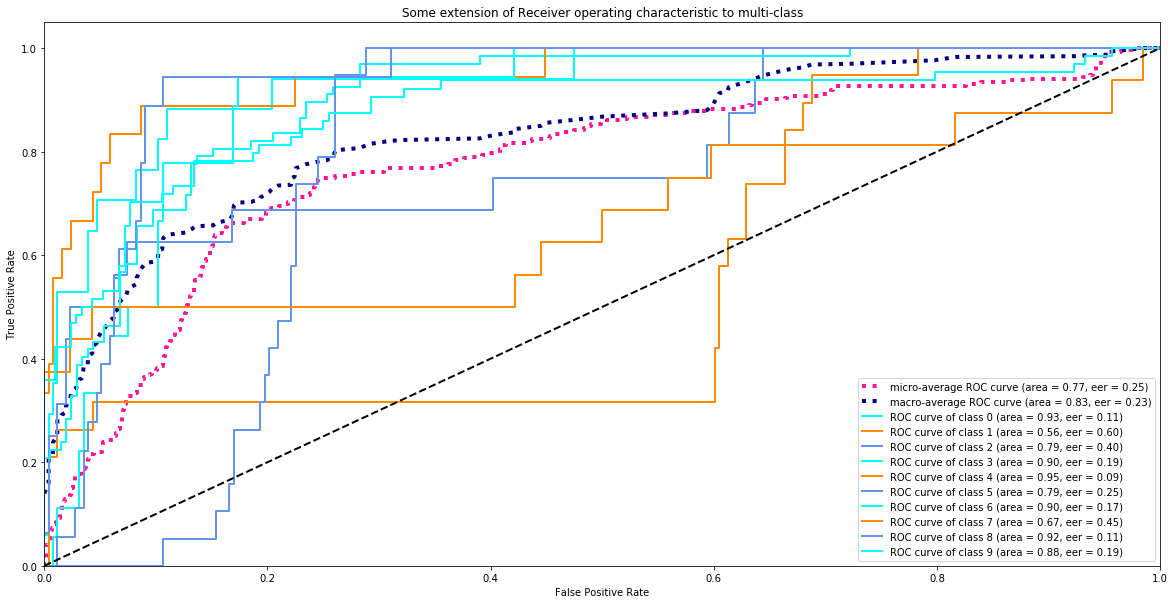

In [51]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
eer = dict()
thres = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thres[i] = roc_curve(label_vector[:, i], score_vector[:, i], pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], thres["micro"] = roc_curve(label_vector.ravel(), score_vector.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
eer["micro"] = fpr["micro"][np.nanargmin(np.abs(fpr["micro"] - (1 - tpr["micro"])))]

for i in range(n_classes):
    eer[i] = fpr[i][np.nanargmin(np.abs(fpr[i] - (1 - tpr[i])))]
    

from scipy import interp
from itertools import cycle
lw = 2
# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
eer["macro"] = fpr["macro"][np.nanargmin(np.abs(fpr["macro"] - (1 - tpr["macro"])))]
# Plot all ROC curves
fig = plt.figure(figsize=(20,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f}, eer = {1:0.2f})'
               ''.format(roc_auc["micro"], eer["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f}, eer = {1:0.2f})'
               ''.format(roc_auc["macro"], eer["macro"]),
         color='navy', linestyle=':', linewidth=4)


colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f}, eer = {2:0.2f})'
             ''.format(i, roc_auc[i], eer[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()